<a href="https://colab.research.google.com/github/michelemiko1/effect_chain_recognition/blob/main/5_def_5effects_preprocessing_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# version of tensorflow used in this project
!pip install tensorflow==2.7
import tensorflow as tf
print(tf.__version__)

In [ ]:
# GPU used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
# RAM ho much
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.2f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.64 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import librosa
import json
import pickle
import numpy as np
import gc
import matplotlib.pyplot as plt

In [ ]:
# constant values
SEGMENT_SECONDS = 2
SAMPLING_RATE = 22050
NUMBER_OF_SEGMENTS = 5
SEGMENT_LENGTH = SAMPLING_RATE * SEGMENT_SECONDS  # 44100

# dataset path
DATASET_PATH_DIVIDED = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/proc_4_guit_5_eff_divided'

# old paths
#JSON_PATH = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5effects_div.json'
#JSON_PATH_RED = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5effects_reduced.json'
#PICKLE_PATH_ENTIRE = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_entire.pickle'
#PICKLE_PATH_ENTIRE_NAMES = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_entire_names.pickle'

# dataset with 4 guitars
#PICKLE_PATH_ENTIRE_NAMES_SEGM = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_entire_names_seg.pickle'  # only names
PICKLE_PATH_ENTIRE_NAMES = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_entire_names.pickle'
PICKLE_PATH_40_PERCENT = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_40_percent_names.pickle'

# 3 guitars + 1 guitar divided (reduced 40%)
PICKLE_PATH_NO_STRAT_RED = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/data_no_strat_red.pickle' 
PICKLE_PATH_STRAT_RED = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/data_strat_red.pickle'

# 3 guitars + 1 guitar divided (entire)
PICKLE_PATH_NO_STRAT_ENTIRE = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/data_no_strat_entire.pickle' 
PICKLE_PATH_STRAT_ENTIRE = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/data_strat_entire.pickle'

PREPROCESSING

In [ ]:
# verify dataset 5 folders each with 2560 audio files
tele_count = 0
strat_count = 0
prs_count = 0
les_count = 0


for i, (path, folders, files) in enumerate(os.walk(DATASET_PATH_DIVIDED)):
  
  if path is not DATASET_PATH_DIVIDED:
    print(i, end = ") ")
    print("path:", path)
    # print("folders:", folders)
    print("len files:", len(files), end="\n\n")

    for name in files:
      if "tele" in name:
        tele_count += 1
      if "strat" in name:
        strat_count += 1
      if "prs" in name:
        prs_count += 1
      if "les" in name:
        les_count += 1

print("tele:", tele_count)
print("strato:", strat_count)
print("prs:", prs_count)
print("les:", les_count)

In [ ]:
# functions for preprocessing
def get_LIST_plugins(file_name):
    """returns the list of plugins associated to a specific audio file
    ex: les_bridge_fing01__01101.wav returns [0, 1, 1, 0, 1]"""

    # get only the string associated to plugin values es: '01101'
    file_name_part = file_name[-9: -4]
    list_plugins = []

    # print("file_name:", file_name)
    
    for number in file_name_part:
        if number == '0':
            list_plugins.append(0)
        if number == '1':
            list_plugins.append(1)

    # print("list plugins:", list_plugins)
    return list_plugins

    
# save file in uniqe file
# - json -> can be stored (24 GB) but not enough memory to be loaded later (for CNN)
# - pickle -> can be stored (6 GB) and can be loaded 

def prepare_dataset(dataset_path, pickle_path):
    """saves mel-spectrogram and label for each audio file (segment)"""

    data = {
        "names":[],
        "spectrogram": [],  # [ spec1, spec2, spec3, ...]
        "labels": []        # [ [0,0,0,1,0], [0,1,0,1,1], [1,1,1,0,0], ...]
    }

    # data_strat = {
    #     "names":[],
    #     "spectrogram": [],  # [ spec1, spec2, spec3, ...]
    #     "labels": []        # [ [0,0,0,1,0], [0,1,0,1,1], [1,1,1,0,0], ...]
    # }
    files_count = 0

    count = 0
    for i, (path, folders, files) in enumerate(os.walk(dataset_path)):

        # path = G:\tesi_4maggio_22\dataset_michele\multilabel\processed_4guitars
        # folders = []
        # files = ['les_bridge_fing01__000.wav', ..., 'les_bridge_fing01__011.wav'], (tot: 3200)

        condition = True
        if path is not dataset_path:

            print("path:", path)
            print("folders:", folders)
            print("len files:", len(files))
            print("file example:", files[:3], end="\n\n")

            for file_name in files:
                if condition:

                    if count % 100 == 0:
                        print("count:", count)

                    file_path = os.path.join(path, file_name)  # get the entire path
                    audio_file, sr = librosa.load(file_path, sr=SAMPLING_RATE)  # load audio file                    
                    y = get_LIST_plugins(file_name)  # get the current label
      
                    # divide the signal in segments and store
                    for segment_index in range(NUMBER_OF_SEGMENTS):

                        # divide signal into segments
                        segment_start = segment_index * SEGMENT_LENGTH
                        current_segment = audio_file[segment_start:segment_start + SEGMENT_LENGTH]

                        # get the mel spectrogram
                        mel_spectrogram = librosa.feature.melspectrogram(y=current_segment, sr=SAMPLING_RATE, n_fft=2048,
                                                                         hop_length=512, n_mels=128)
                        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
                        log_mel_spectrogram = log_mel_spectrogram.T

                        # save data      
                        current_name = file_name[:-4] + f'__segm{segment_index + 1}'             
                        data["spectrogram"].append(log_mel_spectrogram.tolist())
                        data["labels"].append(y)
                        data["names"].append(current_name)

                    count +=1

    with open(pickle_path, "wb") as fb:
        pickle.dump(data, fb)


In [ ]:
# perform preprocessing on 12800 files
prepare_dataset(DATASET_PATH_DIVIDED, PICKLE_PATH_ENTIRE_NAMES_SEGM)

CLASSIFICATION

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import itertools
import librosa.display

In [ ]:
PICKLE_PATH_ENTIRE_NAMES = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5eff_entire_names.pickle'

# functions for loading json files and pickle files
def load_data(data_path):
  with open(data_path, "r") as fp:
      data = json.load(fp)
  return data

def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data

In [ ]:
data_complete = load_data_pickle(PICKLE_PATH_ENTIRE_NAMES)  # 2 GB -> 32 GB RAM

indeces: [59748 43783 12586 43455 45126  2798]


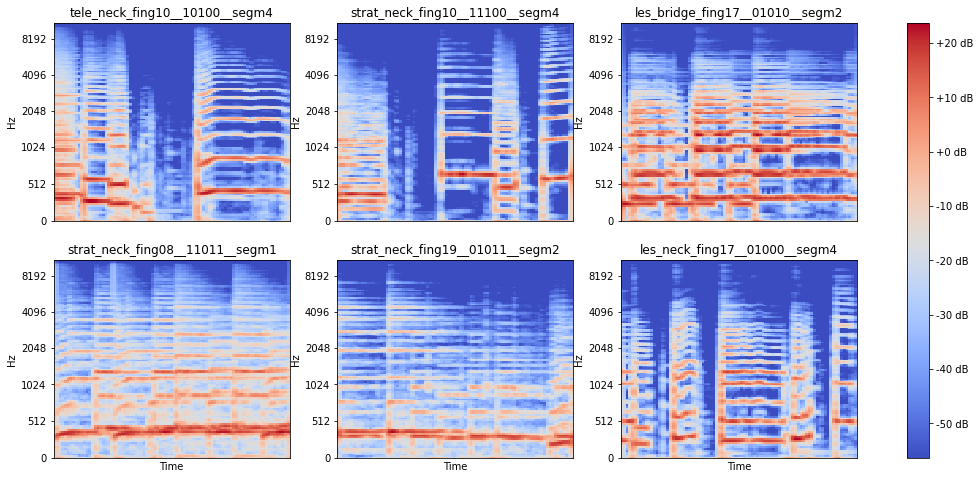

In [ ]:
# plotting 6 random mel spectrograms
dataset_length = len(data_complete["labels"])

indeces = np.random.randint(dataset_length, size=6)  # ex. [ 9467 43814 58297  3831 29183 55152]
print("indeces:", indeces)

spectrograms = []
labels = []

# save names and spectrograms (transposing them)
for index in indeces:
  spectrogram = np.array(data_complete["spectrogram"][index]).T
  spectrograms.append(spectrogram)

  label = data_complete["names"][index]
  labels.append(label)

# position of each spectrgram in the figure
index_config = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)] 

# plot the spectrograms
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
for i in range(6):
  img = librosa.display.specshow(spectrograms[i], y_axis='mel', sr=22050, fmax=11050, ax=ax[index_config[i]])
  #img = librosa.display.specshow(spectrograms[i] - np.max(spectrograms[i]), y_axis='mel', sr=22050, fmax=11050, ax=ax[index_config[i]]) max=0db
  ax[index_config[i]].set(title=labels[i])

ax[1, 0].set_xlabel("Time")
ax[1, 1].set_xlabel("Time")
ax[1, 2].set_xlabel("Time")
fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.show()


In [ ]:
# verify some information about the dataset
def verify_correct_loading(data):
  st = 0
  le = 0
  te = 0
  pr = 0

  count = 0
  for name in data['names']:
    if name[:4] == 'stra':
      st += 1
    if name[:3] == 'les':
      le += 1
    if name[:4] == 'tele':
      te += 1      
    if name[:3] == 'prs':
      pr += 1

  print(st, le, te, pr)

  # print some names
  for i in (13, 500, 3045, 0, 10444):
    print(data_complete['names'][i])


verify_correct_loading(data_complete)


16000 16000 16000 16000
les_bridge_pick24__11010__segm4
les_neck_fing02__11011__segm1
les_neck_fing18__11000__segm1
les_bridge_pick24__11000__segm1
les_bridge_fing03__11000__segm5


In [ ]:
def investigate_data(data):

  # verify some informations about data dictionary
  print(f"type of data is: {type(data)}")
  print(f"dictionary keys of dict are: {data.keys()}")

  # shape
  print(f"shape of data['spectrogram'] is: {np.shape(data['spectrogram'])}")
  print(f"shape of data['labels'] is: {np.shape(data['labels'])}")

  # length
  print(f"len of data['spectrogram'] is: {len(data['spectrogram'])}")
  print(f"len of data['labels'] is: {len(data['labels'])}")

  # type
  print(f"type of data['spectrogram'] is: {type(data['spectrogram'])}")
  print(f"type of data['labels'] is: {type(data['labels'])}")

  # one element
  print(f"one element in data['names'] is: {data['names'][12]}")
  print(f"one element in data['spectrogram'] is: {data['spectrogram'][12]}")
  print(f"one element in data['labels'] is: {data['labels'][12]}")

investigate_data(data_complete)

type of data is: <class 'dict'>
dictionary keys of dict are: dict_keys(['names', 'spectrogram', 'labels'])
shape of data['spectrogram'] is: (64000, 87, 128)
shape of data['labels'] is: (64000, 5)
len of data['spectrogram'] is: 64000
len of data['labels'] is: 64000
type of data['spectrogram'] is: <class 'list'>
type of data['labels'] is: <class 'list'>
one element in data['names'] is: les_bridge_pick24__11010__segm3
one element in data['spectrogram'] is: [[-4.280602931976318, -9.118806838989258, -9.27226448059082, -9.072574615478516, -8.627758979797363, -8.817724227905273, -2.351947784423828, 3.921657085418701, -5.533413887023926, -10.006413459777832, -8.371846199035645, -7.9540205001831055, -6.800868034362793, -5.733122825622559, 9.803675651550293, 12.129571914672852, 10.709514617919922, 5.979294776916504, -13.135383605957031, -5.435576915740967, 0.015465700067579746, 10.090171813964844, 13.958792686462402, 8.89465618133545, 6.815079689025879, 5.139479637145996, 0.03044469654560089, -5

In [ ]:
# functions

def load_data_not_from_file(data):
    X = np.array(data["spectrogram"])
    y = np.array(data["labels"])
    return X, y
    
    
def plot_model_structure(model):
    keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(9, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)  # added mike
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()


def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def verify_input_shape(file):
    shape = np.shape(file)
    print(f"X input shape is {shape}\nthe meaning is (samples, frames, coefficients)")

def normalize_spectrogram(matrix):
    """normalizes between 0 and 1"""
    min = np.min(matrix)
    max = np.max(matrix)
    new_matrix = (matrix - min) / (max - min)
    return new_matrix

def standardize_spectrogram(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    new_matrix = (matrix - mean) / std
    return new_matrix


# problem: slices of the same guitar track can go in different sets (train and test)
def prepare_dataset_for_cnn(data, test_size, validation_size):

    # load data
    X, y = load_data_not_from_file(data)
    
    # - - - NEW 05/09/22 - standardize or normalize spectrogram - - -
    # X_std = map(standardize_spectrogram, X)
    # X_std = np.array(list(X))

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # create train/validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True)

    # add 3rd dimension for CNN
    X_train = X_train[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_valid, X_test, y_train, y_valid, y_test


def build_model(input_shape):
    
    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 4th conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(5, activation='sigmoid'))

    model.summary()
    
    return model


def compile_model(model, learning_rate=0.001):  
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    return model


In [ ]:
def prepare_dataset_for_guitar_cross_validation(data, test_guitar = 'strato'):

    # 64000 segments in total2

    X_test = []
    y_test = []
    N_test = []

    X_train = []
    y_train = []
    N_train = []
    
    count_test = 0
    count_train = 0
    
    # i goes from 0 to 63999
    for i, name in enumerate(data['names']):
      if name[:3] == test_guitar[:3]:   
        
        X_test.append(data['spectrogram'][i])
        y_test.append(data['labels'][i])
        N_test.append(data['names'][i])
        count_test += 1

      else:

        X_train.append(data['spectrogram'][i])
        y_train.append(data['labels'][i])
        N_train.append(data['names'][i])
        count_train += 1

    print(f'train set: {count_train}')
    print(f'test set: {count_test} (guitar: {test_guitar})')


    # from list to numpy array 
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    # add 3rd dimension
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test, N_train, N_test


#X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'tele')

train set: 48000
test set: 16000 (guitar: tele)
input_shape: (87, 128, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 126, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 43, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 31, 32)       0         
 2D)                                            

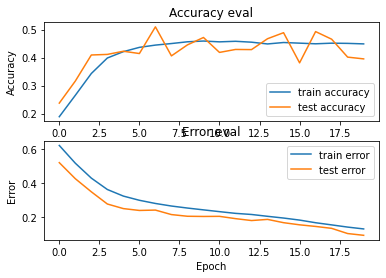

In [ ]:
# import time
# from datetime import datetime
from sklearn.metrics import accuracy_score

MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/CNN_5_effects_entire_dataset.h5'

# name of the model
#time_float = int(time.time()) + 2 * 60 * 60
#date = datetime.fromtimestamp(time_float)

def generic_cnn():
 
  # old - create train, validation and test sets
  #X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_dataset_for_cnn(data_complete, 0.15, 0.15)

  # new - use one guitar as test the other 3 guitars as train
  X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'tele')

  # build the CNN net
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  print(f"input_shape: {input_shape}")

  model = build_model(input_shape)
  model = compile_model(model, learning_rate=0.00005)
  history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=64, epochs=20, shuffle=True)  
                      # con epochs = 50 e learning_rate= 0.00005 -> acc > 97%
                      # keras accuracy: 0.77   (but with segments of same audio file in different sets)
                      # manual_accuracy: 0.97  (idem)

  test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
  print(f"keras accuracy: {test_accuracy}")


  y_pred = model.predict(X_test)
  y_pred = y_pred.round()
  accuracy = accuracy_score(y_test, y_pred)
  print(f"manual_accuracy:", accuracy)

  # plot history

  plot_history(history)
  model.save(MODEL_SAVE_PATH)

generic_cnn()

In [ ]:
# test accuracy_score function
from sklearn.metrics import accuracy_score

a = np.array([[1, 1, 1], [1, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0]])
b = np.array([[1, 1, 1], [1, 0, 0], [0, 1, 0], [1, 1, 1], [0, 0, 0]])

acc = accuracy_score(a, b)
print(acc)


0.8


In [ ]:
# load model
model = keras.models.load_model(MODEL_SAVE_PATH)

INFERENCE

In [ ]:
import librosa
import numpy as np

inference_folder_path = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/inference/inference_5_effects'
inference_folder_path2 = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/inference/inference_3_effects'

SAMPLING_RATE = 22050
SEGMENT_LENGTH = 44100
NUM_SEGMENTS = 5
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/CNN_5_effects_entire_dataset.h5'

In [ ]:
def prepare_data_for_inference(folder_path):
  for path, folders, files in os.walk(folder_path):
    
    # inference data
    inference_data = {
        "file_name": [],
        "spectrogram": []
    }

    # load audio files
    for i, audio_file_name in enumerate(files):

      print(f"preprocessing file number {i+1}")
      # create entire path and load signal
      audio_path = os.path.join(path, audio_file_name)
      signal, _ = librosa.load(audio_path, SAMPLING_RATE)
      
      # slice signal into segments
      for segment_index in range(NUM_SEGMENTS):
        segment_start = segment_index * SEGMENT_LENGTH
        current_segment = signal[segment_start:segment_start + SEGMENT_LENGTH]

        # get the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=current_segment, sr=SAMPLING_RATE, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        log_mel_spectrogram = log_mel_spectrogram.T

        # save data      
        current_name = audio_file_name[:-4] + f'__segm{segment_index + 1}'             
        inference_data["file_name"].append(current_name)
        inference_data["spectrogram"].append(log_mel_spectrogram.tolist())
        

  return inference_data

inference_data = prepare_data_for_inference(inference_folder_path)

preprocessing file number 1
preprocessing file number 2
preprocessing file number 3
preprocessing file number 4
preprocessing file number 5


In [ ]:
# load model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

In [ ]:
# load X and convert to numpy array
X_inference = np.array(inference_data["spectrogram"])

# add 3rd dimension for feeding the CNN
X_inference = X_inference[..., np.newaxis]

# make prediction and round
prediction = model.predict(X_inference)
prediction_rounded = np.round(prediction)
#prediction_rounded_decimals = np.round(prediction, decimals=2)

# print results
for index in range(len(prediction_rounded)):
  print(prediction_rounded[index], end = "  ") 
  print(inference_data["file_name"][index])

[1. 1. 1. 0. 1.]  les_neck_pick05__11101__segm1
[1. 1. 1. 0. 1.]  les_neck_pick05__11101__segm2
[1. 1. 1. 0. 1.]  les_neck_pick05__11101__segm3
[1. 1. 1. 0. 1.]  les_neck_pick05__11101__segm4
[1. 1. 1. 0. 1.]  les_neck_pick05__11101__segm5
[1. 1. 0. 0. 0.]  prs_neck_fing10__11000__segm1
[1. 1. 0. 0. 0.]  prs_neck_fing10__11000__segm2
[1. 1. 0. 0. 0.]  prs_neck_fing10__11000__segm3
[1. 1. 0. 0. 0.]  prs_neck_fing10__11000__segm4
[1. 1. 0. 0. 0.]  prs_neck_fing10__11000__segm5
[1. 0. 1. 0. 1.]  strat_bridge_pick15__10101__segm1
[1. 0. 1. 0. 1.]  strat_bridge_pick15__10101__segm2
[1. 0. 1. 0. 1.]  strat_bridge_pick15__10101__segm3
[1. 0. 1. 0. 1.]  strat_bridge_pick15__10101__segm4
[1. 0. 1. 0. 1.]  strat_bridge_pick15__10101__segm5
[0. 0. 0. 0. 0.]  tele_bridge_fing20__00000__segm1
[0. 0. 0. 0. 0.]  tele_bridge_fing20__00000__segm2
[0. 0. 0. 0. 0.]  tele_bridge_fing20__00000__segm3
[0. 0. 0. 0. 0.]  tele_bridge_fing20__00000__segm4
[0. 0. 0. 0. 0.]  tele_bridge_fing20__00000__segm5
[1. 0

In [ ]:
# load data for next cell
X, y = load_data_not_from_file(data_complete)

In [ ]:
# for this function the generic_cnn should not be a function. In order for this cell to get the value of X_test
predictions = []
index_bad_results = []

for i in range(2000):
  prediction = model.predict(X[i:i+1])
  prediction_rounded = np.around(prediction, decimals=0)
  true_label_value = y[i]
  result = (prediction_rounded==true_label_value)

  count = 0   # count how many False each prediction
  for j in result[0]:
    if j==False:
      count+=1
  if count > 0:
    # save wrong indexes and anwers
    index_bad_results.append(i)
    predictions.append(prediction_rounded)

print(index_bad_results)
print(len(index_bad_results))

In [ ]:
for i, index in enumerate(index_bad_results):
  print('current index:', index)
  print('correct:', data_complete['names'][index][-13:-6])
  print('predicted:', predictions[i])
  print()

GENETIC ALGORITHMS OPTIMIZATION

In [ ]:
from random import randint, uniform, random
import numpy as np
import tensorflow.keras as keras
import gc

In [ ]:
def initialize_first_population(population_size, verbose=True, start_with_low_values=True):
  """Initialize the fist population of Genetic Algorithms(GAs).
  Create each individual randomly"""

  # parameters
  # 0 - HOW MANY CONV. LAYERS                   [min: 1, max: 5]
  
  # 1 - filters          of 1st conv layer      [2 -> 64]
  # 2 - x kernel dim.    of 1st conv layer      [2 -> 7]
  # 3 - y kernel dim.    of 1st conv layer      [2 -> 7]
  # 4 - x size           of 1st maxpool layer   [1 -> 2]
  # 5 - y size           of 1st maxpool layer   [1 -> 2]

  #  6,  7,  8,  9, 10 - same but considering 2nd layer (if present)
  # 11, 12, 13, 14, 15 - same but considering 3rd layer (if present)
  # 16, 17, 18, 19, 20 - same but considering 4th layer (if present)
  # 21, 22, 23, 24, 25 - same but considering 5th layer (if present)
  # ----------------------------------------------------
  
  # 26 - HOW MANY DENSE LAYERS [min: 1, max: 3]
  
  # 27 - neurons         of 1st dense layer     [2 -> 64]
  # 28 - dropout prob.   of 1st dense layer     [0 -> 0.5]
  # 29 - neurons         of 2nd dense layer (if present)
  # 30 - dropout prob.   of 2nd dense layer (if present)
  # 31 - neurons         of 3rd dense layer (if present)
  # 32 - dropout prob.   of 3rd dense layer (if present)

  print_info_first_individual = verbose
  
  
  # list that will contain all the individuals
  population = []

  for individual_index in range(population_size):
    
    if verbose:
      print(f"Creating individual {individual_index + 1} out of {population_size}")
    
    current_individual = [0] * 33  # [0, 0, 0...., 0]
    
    # define how many conv layers and dense layers
    current_individual[0] = randint(1, 5)
    current_individual[26] = randint(1, 3)

    if print_info_first_individual:
      print("- working on # of filters' of conv layers  (index: 1, 6, 11, 16, 21)")
    for list_index in range(1, 22, 5):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working on x and y kernel dimensions     (index: 2, 3, 7, 8, 12, 13, 17, 18, 22, 23)")
    for list_index in range(2, 23, 5):
      current_individual[list_index] = randint(2, 7)
      current_individual[list_index + 1] = randint(2, 7)

    if print_info_first_individual:
      print("- working on x and y MaxPooling size       (index: 4, 5, 9, 10, 14, 15, 19, 20, 24, 25)")
    for list_index in range(4, 25, 5):
      current_individual[list_index] = randint(1, 2)
      current_individual[list_index + 1] = randint(1, 2)

    if print_info_first_individual:
      print("- working # of neurons in dense layers     (index: 27, 29, 31)")
    for list_index in range(27, 32, 2):
      if start_with_low_values:
        current_individual[list_index] = randint(2, 8)
      else:
        current_individual[list_index] = randint(2, 64)

    if print_info_first_individual:
      print("- working dropout prob. after dense layers (index: 28, 30, 32)")
    for list_index in range(28, 33, 2):
      # round approx. the number to second decimal
      current_individual[list_index] = round(uniform(0.0, 0.5), 2)

    if verbose:
      print(current_individual, end="\n\n")

    population.append(current_individual)

    print_info_first_individual = False
      
  return population

In [ ]:
# build and compile the model
def build_and_compile_model(indiv, input_shape):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    #model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


  print(model.summary())

  return model

#individual = [2, 44, 3, 7, 1, 1, 33, 2, 2, 1, 2, 51, 6, 5, 1, 1, 28, 5, 5, 2, 1, 36, 3, 4, 2, 1, 3, 9, 0.15, 63, 0.13, 38, 0.25]
#build_and_compile_model(individual, (78, 80, 1))

In [ ]:
#INPUT_SHAPE = (87, 128)
from sklearn.metrics import accuracy_score


def fitness_evaluation(individual, dataset):

  # print current individual
  print(f"fitness_evaluation function. Individual considered:\n{individual}")

  # get train and test data from dataset (or it is better to make here the train/test split??)
  (X_train, y_train), (X_valid, y_valid) = dataset


  # --- NEW - CONSIDER ONLY A PART OF THE DATASET FOR EVALUATION ---
  #X_reduced, X_discarded, y_reduced, y_discaded = train_test_split(X_train, y_train, test_size = 0.7, random_state=7, shuffle=True)


  # build CNN associated to the individual
  input_shape = np.shape(X_train[1])
  #print(f"input_shape: {input_shape}")
  model = build_and_compile_model(individual, input_shape)

  # evaluate the model/individual (implementing early stopping??)
  model.fit(X_train, y_train, epochs=15, batch_size=64, shuffle=True, validation_data = (X_valid, y_valid))

  # get the accuracy on valid set (not used now)
  loss, accuracy = model.evaluate(X_valid, y_valid)   # can use loss intead of accuracy

  # NEW - sklearn accuracy
  y_pred = model.predict(X_valid)
  y_pred = y_pred.round()
  sklearn_accuracy = accuracy_score(y_valid, y_pred)
  print(f"sklearn_accuracy:", sklearn_accuracy)

  # i can consider to return - (1/loss)
  return sklearn_accuracy

In [ ]:


# population evaluation (funzione testata)
def population_evaluation(population, dataset):
  """population_evaluation gets the performace of each individual in the current population. 
  It stores in a dictionary 3 elements: the current population and the fitness and the probability
  of each individal"""
  
  # print individual to verify if population is correct
  #print(f"POPULATION EVALUATION\n Here the list of the {POLPULATION_SIZE} individuals")
  #for individual in population:
  #  print(individual)

  # dictionary to store information about population
  population_eval ={
      "population":[],
      "fitness":[],
      "probability":[],
      "best_individual": [],
      "statistics": {"min":0, "max":0, "average":0}
  }
  # save pupulation into dictionary
  population_eval["population"] = population.copy()

  # perform and save fitness for each individual - enumerate counts starting from 1
  for i, individual in enumerate(population, 1):

    # Here a CNN is built and evaluated
    print(f"\n({i}/{POPULATION_SIZE})", end=" - ")
    fitness = fitness_evaluation(individual, dataset)

    # free memory occupied by keras model
    gc.collect()


    population_eval["fitness"].append(fitness)
  
  # perform and save probability for each individual
  sum_of_fitnesses = np.sum(population_eval["fitness"])
  for fitness_value in population_eval["fitness"]:
    probability_value = fitness_value / sum_of_fitnesses
    population_eval["probability"].append(probability_value)

  # save best individual
  best_individual_index = np.argmax(population_eval["fitness"])
  best_individual = population_eval["population"][best_individual_index]
  population_eval["best_individual"].append(best_individual)

  # save min, max and average
  max = np.max(population_eval["fitness"])
  min = np.min(population_eval["fitness"])
  average = np.average(population_eval["fitness"])

  population_eval["statistics"]["min"] = min
  population_eval["statistics"]["max"] = max
  population_eval["statistics"]["average"] = average

  return population_eval


In [ ]:
# selection function
def selection(population_eval):
  """selects one individual based on roulette wheels selection"""

  # implement roulette wheel selection
  R = random()
  #print(R)

  # first iter (p.1), second iter (p.1 + p.2), ...
  sum_of_probabilities = 0
  for index in range(len(population_eval["probability"])):

    sum_of_probabilities += population_eval["probability"][index]

    if sum_of_probabilities > R:

      selected_individual = population_eval["population"][index]
      break

  return selected_individual, index


def select_two_individuals(population_eval):
  """selects two different individuals in current population """

  first_individual, first_index = selection(population_eval)
  second_individual, second_index = selection(population_eval)

  while first_index == second_index:
    second_individual, second_index = selection(population_eval)

  return first_individual, second_individual


# test selection
def test_selection():
  indiv = [[1,2,3], [4,5,6], [7,8,9], [10,11,12], [2, 3, 2]]
  indiv_prob = [0.1, 0.2, 0.2, 0.4, 0.1]


  p_eval = {
      "population": indiv,
      "probability": indiv_prob
  }
  print(select_two_individuals(p_eval))
  # return the two individuals

#test_selection()

In [ ]:
# crossover function
def single_point_crossover(individual_1, individual_2, CROSSOVER_PROB):
  """performs single point crossover between two individuals with a certain probability.
  returns 1' individual if crossover is not performed """

  # single point crossover
  random_crossover_point = randint(1, len(individual_1)-1)  # how many elements I keep from 1' individual
  #print(f"crossover_point: {random_crossover_point}")

  # create new individual
  new_individual = []
  for index in range(len(individual_1)):
    if index < random_crossover_point:
      new_individual.append(individual_1[index])
    else:
       new_individual.append(individual_2[index])

  # consider crossover probability
  random_value = random()
  #print("random_value:", random_value)
  if CROSSOVER_PROB > random_value:
    return new_individual
  return individual_1
 
def test_crossover():
  ind_1 = [1, 2, 3, 4, 5, 6, 7, 8, 9 ]
  ind_2 = [10,20,30,40,50,60,70,80,90]

  print(single_point_crossover(ind_1, ind_2, 0.8))

In [ ]:
# mutation function
def mutation(individual, MUTATION_PROB):

  # parameters
  # 0 - HOW MANY CONV. LAYERS                   [min: 1, max: 5]
  
  # 1 - filters          of 1st conv layer      [2 -> 64]
  # 2 - x kernel dim.    of 1st conv layer      [2 -> 7]
  # 3 - y kernel dim.    of 1st conv layer      [2 -> 7]
  # 4 - x size           of 1st maxpool layer   [1 -> 2]
  # 5 - y size           of 1st maxpool layer   [1 -> 2]

  #  6,  7,  8,  9, 10 - same but considering 2nd layer (if present)
  # 11, 12, 13, 14, 15 - same but considering 3rd layer (if present)
  # 16, 17, 18, 19, 20 - same but considering 4th layer (if present)
  # 21, 22, 23, 24, 25 - same but considering 5th layer (if present)
  # ----------------------------------------------------
  
  # 26 - HOW MANY DENSE LAYERS [min: 1, max: 3]
  
  # 27 - neurons         of 1st dense layer     [2 -> 64]
  # 28 - dropout prob.   of 1st dense layer     [0 -> 0.5]
  # 29 - neurons         of 2nd dense layer (if present)
  # 30 - dropout prob.   of 2nd dense layer (if present)
  # 31 - neurons         of 3rd dense layer (if present)
  # 32 - dropout prob.   of 3rd dense layer (if present)

  # define how many conv layers and dense layers
    
  indeces_with_filters_or_neurons = [1, 6, 11, 16, 21, 27, 29, 31]
  indeces_with_kernel_dim = [2, 3, 7, 8, 12, 13, 17, 18, 22, 23]
  indeces_with_MaxPool_dim = [4, 5, 9, 10, 14, 15, 19, 20, 24, 25]
  indeces_with_dropout_prob = [28, 30, 32]

  for index in range(len(individual)):

    random_number = random()
    if MUTATION_PROB > random_number:

      # new - use lower probability (half!) for number of layers
      if random() > 0.5:  # not in thesis implementation
        if index == 0:
          individual[index] = randint(1, 5)

        if index == 26:
          individual[index] = randint(1, 3)

      # consider conv filters and neurons in dense layer
      if index in indeces_with_filters_or_neurons:
        new_value = individual[index] + randint(-3, 3) + 5  # in thesis implementation +3 (not + 5)
        # if value is not in range try again
        while (not 2 <= new_value <= 64):
          new_value = individual[index] + randint(-3, 3) + 5
        individual[index] = new_value

      # consider kernel dimension
      if index in indeces_with_kernel_dim:
        individual[index] = randint(2, 7)

      # consider maxpool dimension
      if index in indeces_with_MaxPool_dim:
        individual[index] = randint(1, 2)

      # consider dropout probability
      if index in indeces_with_dropout_prob:

        variation = (random() - 0.5) * 0.2  # from [-0.1 to 0.1) 
        new_value = round(individual[index] + variation, 2)
        # if value is not in range try again (try to avoid -0.0)

        while (not 0.001 <= new_value <= 0.5):
          variation = (random() - 0.5) * 0.2
          new_value = round(individual[index] + variation, 2)
        individual[index] = new_value 

  # I'm not makineg individual.copy at the beginning, so I'm modifying the individual
  return individual

    
   
#individual = [2, 44, 3, 7, 1, 1, 33, 2, 2, 1, 2, 51, 6, 5, 1, 1, 28, 5, 5, 2, 1, 36, 3, 4, 2, 1, 3, 9, 0.15, 63, 0.13, 38, 0.25]
#print(mutation(individual, 0.1))

In [ ]:
# main



# ------ LOADING DATA

#DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/4__thesis/Datasets/effected_5effects_reduced.json'

def load_data(data_path):
  with open(data_path, "r") as fp:
      data = json.load(fp)
  return data

# ------


POPULATION_SIZE = 8
NUM_GENERATIONS = 12
CROSSOVER_PROB = 0.8
MUTATION_PROB = 0.3

def main(verbose=True):

  #data = load_data_pickle(PICKLE_PATH_ENTIRE_NAMES) - new 1/3

  statistics_dict = {
      "best_individuals":[],
      "min":[],
      "max":[],
      "average":[]
  }

  # build the first population
  population = initialize_first_population(POPULATION_SIZE, verbose=False)
  if verbose:
    print("(main) first population initialized")
    for indiv in population:
      print(indiv)


  # new - load data separated use strato for test phase
  data_train = load_data_pickle(PICKLE_PATH_NO_STRAT_ENTIRE)
  data_test = load_data_pickle(PICKLE_PATH_STRAT_ENTIRE)
  
  X_train, y_train = load_data_not_from_file(data_train)
  X_test, y_test = load_data_not_from_file(data_test)
  
  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  data = (X_train, y_train), (X_test, y_test)

  del data_train
  del data_test

  #load dataset
  #X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_dataset_for_cnn(data, 0.2, 0.2) - new 2/3
  #data = (X_train, y_train), (X_valid, y_valid) - new 3/3
  
  
  if verbose:
    print("\n(main) dataset loaded")
    print(f"X_train dimension: {np.shape(X_train)}")

  
  # START WITH GENERATIONS
  for generation in range(NUM_GENERATIONS):

    # EVALUATE
    
    print(f"\n - GENERATION {generation+1}\n")

    population_eval  = population_evaluation(population, data)

    # save statistics
    statistics_dict["best_individuals"].append(population_eval['best_individual'][0])
    statistics_dict["min"].append(population_eval['statistics']["min"])
    statistics_dict["max"].append(population_eval['statistics']["max"])
    statistics_dict["average"].append(population_eval['statistics']["average"])

    # consider elitism - save best individual for next generation
    survived_individual = population_eval['best_individual'][0].copy()

    if verbose:
      print(f"\n(main) {generation+1}' population has been evaluated")
      print(f"best individual: {population_eval['best_individual']}")
      print(f"statistics: {population_eval['statistics']}")

    # NEW POPULATION - selection, crossover, mutation

    new_population = []
    new_population.append(survived_individual)

    for i in range(POPULATION_SIZE - 1):
      
      # selection
      individual_1, individual_2 = select_two_individuals(population_eval)

      # crossover
      crossed_individual = single_point_crossover(individual_1,individual_2, CROSSOVER_PROB)

      # mutation
      mutated_individual = mutation(crossed_individual, MUTATION_PROB)

      # append to new population
      new_population.append(mutated_individual)

    population = new_population  # or new_population.copy() ?

    print(f"(main) {generation+2}' population initialized")
    for indiv in population:
      print(indiv)

  return statistics_dict


statistics = main()


statistics_path = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/statistics_6ott.json'
with open(statistics_path, "w") as fp:
    json.dump(statistics, fp, indent=4)

#population_eval ={
#      "population":[],
#      "fitness":[],
#      "probability":[],
#      "best_individual": [],
#      "statistics": {"min":0, "max":0, "average":0}
#  }

Output streaming troncato alle ultime 5000 righe.
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 87, 128, 9)        324       
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 44, 128, 9)       0         
 g2D)                                                            
                                                                 
 batch_normalization_82 (Bat  (None, 44, 128, 9)       36        
 chNormalization)                                                
                                                                 
 conv2d_83 (Conv2D)          (None, 44, 128, 6)        546       
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 22, 128, 6)       0         
 g2D)                                                            
                          

In [ ]:
import json

statistics_path = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/statistics_5ott.json'
with open(statistics_path, "r") as fp:
    stat_genetic = json.load(fp)

dict_keys(['best_individuals', 'min', 'max', 'average'])


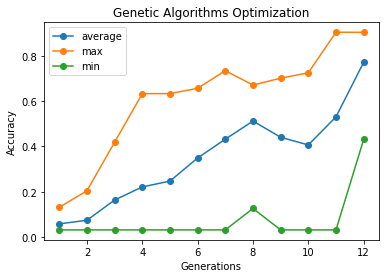

In [ ]:
import matplotlib.pyplot as plt

# load ad plot statistics
print(stat_genetic.keys())

#print(statistics['average'])
#print(statistics['best_individuals'])

generations = list(range(1, 13))

plt.plot(generations, stat_genetic['average'], label='average', marker='o')
plt.plot(generations, stat_genetic['max'], label='max', marker='o')
plt.plot(generations, stat_genetic['min'], label='min', marker='o')

plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.title('Genetic Algorithms Optimization')
plt.legend()
plt.show()

#savepath = 
plt.savefig()


IMPLEMENT BEST MODEL

In [ ]:
best_indiv_1 = statistics['best_individuals'][-1]
best_indiv_2 = statistics['best_individuals'][-2]

print(best_indiv_1)
print(best_indiv_2)

[5, 6, 2, 2, 2, 1, 23, 6, 3, 1, 1, 10, 4, 7, 2, 2, 24, 4, 6, 2, 1, 9, 4, 7, 1, 1, 1, 21, 0.18, 6, 0.14, 12, 0.39]
[5, 6, 4, 2, 1, 1, 19, 6, 3, 1, 1, 9, 4, 7, 1, 2, 22, 4, 6, 2, 1, 8, 4, 2, 1, 1, 1, 21, 0.18, 6, 0.14, 12, 0.29]


In [ ]:
import json
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import gc


In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
# build and compile the model
def build_and_compile_model(indiv, input_shape):

  model = keras.Sequential()

  # create first conv layer + pooling layer
  model.add(keras.layers.Conv2D(filters=indiv[1], kernel_size=(indiv[2], indiv[3]), input_shape=input_shape, activation='relu', padding='same'))
  model.add(keras.layers.MaxPool2D(pool_size=(indiv[4], indiv[5]), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # create other conv layers + pooling layers
  remain_conv_layer = indiv[0] - 1
  for i in range(6, 6 + remain_conv_layer * 4, 5):
    model.add(keras.layers.Conv2D(filters=indiv[i], kernel_size=(indiv[i+1], indiv[i+2]), activation='relu', padding='same'))
    #model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(indiv[i+3], indiv[i+4]), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
  # flatten
  model.add(keras.layers.Flatten())

  # create dense layers + dropout
  dense_layers = indiv[26]  # how many dense layers we have
  for j in range(27, 27 + dense_layers * 2, 2):
    model.add(keras.layers.Dense(units=indiv[j], activation='relu'))
    model.add(keras.layers.Dropout(indiv[j+1]))

  # add final layer
  model.add(keras.layers.Dense(units=5, activation='sigmoid'))

  # compile the model
  optimizer = keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


  print(model.summary())

  return model

In [ ]:

def prepare_dataset_for_guitar_cross_validation(data, test_guitar = 'strato'):

    # 64000 segments in total2

    X_test = []
    y_test = []
    N_test = []

    X_train = []
    y_train = []
    N_train = []
    
    count_test = 0
    count_train = 0
    
    # i goes from 0 to 63999
    for i, name in enumerate(data['names']):
      if name[:3] == test_guitar[:3]:   
        
        X_test.append(data['spectrogram'][i])
        y_test.append(data['labels'][i])
        N_test.append(data['names'][i])
        count_test += 1

      else:

        X_train.append(data['spectrogram'][i])
        y_train.append(data['labels'][i])
        N_train.append(data['names'][i])
        count_train += 1

    print(f'train set: {count_train}')
    print(f'test set: {count_test} (guitar: {test_guitar})')


    # from list to numpy array 
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    # add 3rd dimension
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test, N_train, N_test


#X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'tele')

In [ ]:
# load statistics

def load_data_pickle(data_path):
  with open(data_path, "rb") as fp:
      data = pickle.load(fp)
  return data
  
statistics_path = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/statistics_5ott.json'

with open(statistics_path, 'r') as f:
  statistics = json.load(f)

train set: 48000
test set: 16000 (guitar: tele)
max value obtained is: 0.905
best individual is:
 [5, 6, 4, 2, 1, 1, 19, 6, 3, 1, 1, 9, 4, 7, 1, 2, 22, 4, 6, 2, 1, 8, 4, 2, 1, 1, 1, 21, 0.18, 6, 0.14, 12, 0.29]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 87, 128, 6)        30        
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 44, 128, 6)       0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 44, 128, 6)       24        
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 128, 23)       2507      
                                         

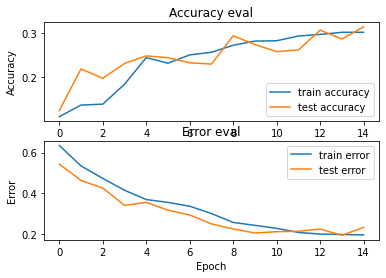

500/500 [==============================] - 3s 5ms/step - loss: 0.2314 - accuracy: 0.3145
test_accuracy: 0.31450000405311584
sklearn accuracy:  0.506125


In [ ]:
# destroy previous data to free space

gc.collect()

# load entire dataset
data_complete = load_data_pickle(PICKLE_PATH_ENTIRE_NAMES)

# new - test with 1 guitar as test set (ex: tele)
X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, 'tele')
del data_complete

# implement the best model found
best_index = np.argmax(statistics['max'])
print('max value obtained is:', statistics['max'][best_index])
best_individual = statistics["best_individuals"][best_index]
print("best individual is:\n", best_individual)

# obtained looking at the optimiz process.. few parameters
best_individual = [5, 11, 4, 2, 1, 2, 20, 6, 2, 1, 1, 5, 4, 6, 2, 1, 17, 2, 6, 2, 2, 12, 4, 2, 1, 2, 2, 15, 0.25, 18, 0.09, 16, 0.09]

# second best of the optimization
second_best_individual = [5, 6, 2, 2, 2, 1, 23, 6, 3, 1, 1, 10, 4, 7, 2, 2, 24, 4, 6, 2, 1, 9, 4, 7, 1, 1, 1, 21, 0.18, 6, 0.14, 12, 0.39]
#best_individual_example = [3, 15, 5, 7, 2, 2, 6, 2, 6, 1, 2, 15, 4, 6, 1, 1, 35, 7, 3, 2, 2, 29, 3, 6, 1, 2, 1, 40, 0.16, 55, 0.37, 8, 0.36]

input_shape = np.shape(X_train[1])
best_model = build_and_compile_model(second_best_individual, input_shape)
history = best_model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data = (X_test, y_test))
plot_history(history)

# evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("test_accuracy:", test_accuracy)

# manual accuracy
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test)
y_pred = y_pred.round()
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("sklearn accuracy: ", sklearn_accuracy)


In [ ]:
#data_strat = load_data_pickle(PICKLE_PATH_STRAT_RED)
#X_strat, y_strat = load_data_not_from_file(data_strat)


def which_class_wrong(y_pred, y_strat):
  errors_dict = {
      "overdrive": 0,
      "chorus": 0,
      "tremolo": 0,
      "delay": 0,
      "reverb": 0
  }

  for i, (pred, true) in enumerate(zip(y_pred, y_strat)):
    #print(f"{i+1} ) pred: {pred}, true: {true}")

    if pred[0] != true[0]:
      errors_dict["overdrive"] += 1
    if pred[1] != true[1]:
      errors_dict["chorus"] += 1
    if pred[2] != true[2]:
      errors_dict["tremolo"] += 1
    if pred[3] != true[3]:
      errors_dict["delay"] += 1
    if pred[4] != true[4]:
      errors_dict["reverb"] += 1

  #error_list = [errors_dict[curren_effect] for curren_effect in errors_dict.keys()]

  return errors_dict


In [ ]:
# new - want to consider the other effects when dealing with effects errors
# ex: when delay fails knowing which other effects fail 

def which_class_wrong_when_overdrive_wrong(y_pred, y_strat):
  errors_when_overdrive_wrong = {
      #"overdrive": 0,
      "chorus": 0,
      "tremolo": 0,
      "delay": 0,
      "reverb": 0
  }

  for i, (pred, true) in enumerate(zip(y_pred, y_strat)):
    #print(f"{i+1} ) pred: {pred}, true: {true}")

    if pred[0] != true[0]:
      errors_when_overdrive_wrong["overdrive"] += 1
      if pred[1] != true[1]:
        errors_when_overdrive_wrong["chorus"] += 1
      if pred[2] != true[2]:
        errors_when_overdrive_wrong["tremolo"] += 1
      if pred[3] != true[3]:
        errors_when_overdrive_wrong["delay"] += 1
      if pred[4] != true[4]:
        errors_when_overdrive_wrong["reverb"] += 1

  #error_list = [errors_dict[curren_effect] for curren_effect in errors_dict.keys()]

  return errors_when_overdrive_wrong


  # da fare: aggiungi questa funzione durante "evaluate_model_no_start" per vedere 
  # che correlazione c'è fra errore su overdr. e altri effetti
   

In [ ]:
def load_data_not_from_file(data):
    X = np.array(data["spectrogram"])
    y = np.array(data["labels"])
    return X, y


def calculate_mean_std_class_errors(list_of_dict):
  over = []
  chor = []
  trem = []
  dela = []
  reve = []

  for dic in list_of_dict:
    over.append(dic["overdrive"])
    chor.append(dic["chorus"])
    trem.append(dic["tremolo"])
    dela.append(dic["delay"])
    reve.append(dic["reverb"])

  mean_dict = {
      "over_mean": np.mean(over),
      "chor_mean": np.mean(chor),
      "trem_mean": np.mean(trem),
      "dela_mean": np.mean(dela),
      "reve_mean": np.mean(reve)
  }
  std_dict = {
      "over_std": np.std(over),
      "chor_std": np.std(chor),
      "trem_std": np.std(trem),
      "dela_std": np.std(dela),
      "reve_std": np.std(reve)
  }
  return mean_dict, std_dict
  


# train model without starto data reduced
from sklearn.metrics import accuracy_score

#best_indiv_example = [3, 15, 5, 7, 2, 2, 6, 2, 6, 1, 2, 15, 4, 6, 1, 1, 35, 7, 3, 2, 2, 29, 3, 6, 1, 2, 1, 40, 0.16, 55, 0.37, 8, 0.36]
best_individual_few_param_5ott = [5, 11, 4, 2, 1, 2, 20, 6, 2, 1, 1, 5, 4, 6, 2, 1, 17, 2, 6, 2, 2, 12, 4, 2, 1, 2, 2, 15, 0.25, 18, 0.09, 16, 0.09]

def evaluate_model_no_start(best_individual, test_guitar, repetitions=4):
  
  statistics = {
      "manual_accuracy": [],
      "class_errors": [],
      "class_errors_mean": 0,
      "class_errors_std": 0,
      "accuracy_mean": 0,
      "accuracy_std": 0,
  }

  # load data as X, y
  # data_no_strat = load_data_pickle(path_no_strat)
  # data_strat = load_data_pickle(path_strat)

  # X_no_strat, y_no_strat = load_data_not_from_file(data_no_strat)
  # X_strat, y_strat = load_data_not_from_file(data_strat)

  # X_no_strat = X_no_strat[..., np.newaxis]
  # X_strat = X_strat[..., np.newaxis]

  # new 
  # load entire dataset
  data_complete = load_data_pickle(PICKLE_PATH_ENTIRE_NAMES)

  # new - test with 1 guitar as test set (ex: tele)
  X_train, X_test, y_train, y_test, N_train, N_test = prepare_dataset_for_guitar_cross_validation(data_complete, test_guitar)
  del data_complete


  input_shape = np.shape(X_train[0])
  print(f"input shape: {input_shape}")

  # delete data to free memory
  # del data_no_strat
  # del data_strat
  # gc.collect()

  for i in range(repetitions):
    
    gc.collect()
    # build, train, evaluate model
    
    model = build_and_compile_model(best_individual, input_shape)
    history = model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data=(X_test, y_test))

    # manual accuracy
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    accuracy = accuracy_score(y_test, y_pred)
    print("manual accuracy: ", accuracy)

    # how many wrong labels for each class
    class_errors_dict = which_class_wrong(y_test, y_pred)

    statistics["class_errors"].append(class_errors_dict)
    statistics["manual_accuracy"].append(accuracy)
  statistics["accuracy_mean"] = np.mean(statistics["manual_accuracy"])
  statistics["accuracy_std"] = np.std(statistics["manual_accuracy"])

  # gest statistics of class errors
  class_mean, class_std = calculate_mean_std_class_errors(statistics["class_errors"])
  statistics["class_errors_mean"] = class_mean
  statistics["class_errors_std"] = class_std


  return statistics

statistics = evaluate_model_no_start(best_individual=best_individual_few_param_5ott, test_guitar='les', repetitions=3)


train set: 48000
test set: 16000 (guitar: les)
input shape: (87, 128, 1)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 87, 128, 11)       99        
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 87, 64, 11)       0         
 g2D)                                                            
                                                                 
 batch_normalization_80 (Bat  (None, 87, 64, 11)       44        
 chNormalization)                                                
                                                                 
 conv2d_81 (Conv2D)          (None, 87, 64, 20)        2660      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 87, 64, 20)       0         
 g2D)                                         

In [ ]:
guitar_name = 'les'
accuracies_path = '/content/drive/MyDrive/Colab Notebooks/4__thesis/models/statistics_' + guitar_name + '.json'

with open(accuracies_path, 'w') as fp:
  json.dump(statistics, fp, indent=4)

print(statistics)

{'manual_accuracy': [0.86825, 0.8815, 0.8368125], 'class_errors': [{'overdrive': 989, 'chorus': 106, 'tremolo': 165, 'delay': 989, 'reverb': 52}, {'overdrive': 777, 'chorus': 54, 'tremolo': 105, 'delay': 930, 'reverb': 131}, {'overdrive': 557, 'chorus': 95, 'tremolo': 171, 'delay': 1850, 'reverb': 69}], 'class_errors_mean': {'over_mean': 774.3333333333334, 'chor_mean': 85.0, 'trem_mean': 147.0, 'dela_mean': 1256.3333333333333, 'reve_mean': 84.0}, 'class_errors_std': {'over_std': 176.3733413970364, 'chor_std': 22.37558192911788, 'trem_std': 29.79932885150268, 'dela_std': 420.4761850833198, 'reve_std': 33.95094500402996}, 'accuracy_mean': 0.8621875, 'accuracy_std': 0.01874048369617675}


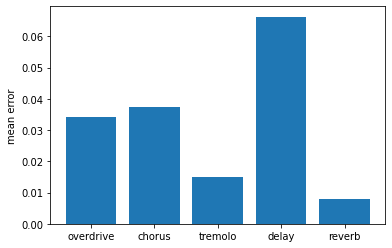

In [ ]:
# plot
tot_tes_set = 16000
labels = ['overdrive', 'chorus', 'tremolo', 'delay', 'reverb']
values = list(statistics['class_errors_mean'].values())
values = np.array(values)
values_normalized = values / tot_tes_set

bars = plt.bar(labels, values_normalized)
plt.ylabel('mean error')
plt.show()

In [ ]:
# # implement 5-fold cross-validation
# from sklearn.model_selection import RepeatedKFold
# from sklearn.metrics import accuracy_score
# N_SPLITS = 5

# best_indiv_example = [3, 15, 5, 7, 2, 2, 6, 2, 6, 1, 2, 15, 4, 6, 1, 1, 35, 7, 3, 2, 2, 29, 3, 6, 1, 2, 1, 40, 0.16, 55, 0.37, 8, 0.36]


# def evaluate_model_with_statistics(data_path, best_individual):
#   accuracy_list = []

#   # load data as X, y
#   data = load_data_pickle(data_path)
#   X, y = load_data_not_from_file(data)

#   # delete data to free memory
#   del data
#   gc.collect()

#   # create splits for 5-fold cross-validation
#   cv = RepeatedKFold(n_splits=N_SPLITS, n_repeats=1, random_state=10)

#   # cv.split(X) returns a generator that returns indices of train and test set
#   # es: 1' iteration could return a tuple: ([0, 1, 3, 4, 5, 7], [2, 6]) ..are numpy arrays
#   for train_index, test_index in cv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # add new dimension to feed the CNN
#     X_train = X_train[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]

#     # build compile and train the model
#     gc.collect()
#     input_shape = np.shape(X_train[0])
#     model = build_and_compile_model(best_individual, input_shape)
#     model.fit(X_train, y_train, epochs = 15, batch_size=40)

#     # make predictions and round
#     y_pred = model.predict(X_test)
#     y_pred = y_pred.round()
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"current accuracy: %.2f:" % accuracy)

#     accuracy_list.append(accuracy)
    
  
#   accuracy_mean = np.mean(accuracy_list)
#   accuracy_std = np.std(accuracy_list)

#   return accuracy_mean, accuracy_std, accuracy_list


In [ ]:
#accuracy_mean, accuracy_std, accuracy_list = evaluate_model_with_statistics(PICKLE_PATH_ENTIRE_NAMES_SEGM, best_indiv_example)

In [ ]:
# # accuracy_mean, accuracy_std, accuracy_list
# print(accuracy_mean, accuracy_std)
# print(accuracy_list)

0.9591093749999999 0.026716310195623028
[0.963515625, 0.965234375, 0.978125, 0.981171875, 0.9075]


ELABORATE RESULTS